# Imports

In [1]:
import copy
import math
import os
import random
import time
import pickle
from datetime import datetime
from itertools import combinations

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats
import torch
import torch.nn as nn
import yaml
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from ofa.model_zoo import ofa_net
from ofa.tutorial.accuracy_predictor import AccuracyPredictor
from ofa.tutorial.evolution_finder import ArchManager, EvolutionFinder
from ofa.tutorial.flops_table import FLOPsTable
from ofa.tutorial.imagenet_eval_helper import (
    evaluate_ofa_specialized,
    evaluate_ofa_subnet,
)

# Once-for-All
from ofa.tutorial.latency_table import LatencyEstimator, LatencyTable
from ofa.utils import download_url

# pymoo
from pymoo.core.individual import Individual
from pymoo.core.mutation import Mutation
from pymoo.core.population import Population
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.variable import Choice
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.mutation.rm import ChoiceRandomMutation
from pymoo.operators.selection.rnd import RandomSelection
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.indicators.hv import HV
from pymoo.core.callback import Callback
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from torchvision import datasets, transforms
from tqdm import tqdm

## from ofa.tutorial.accuracy_predictor import AccuracyPredictor
## from ofa.tutorial.flops_table import FLOPsTable
## from ofa.tutorial.latency_table import LatencyTable
## from ofa.tutorial.evolution_finder import EvolutionFinder
## from ofa.tutorial.imagenet_eval_helper import evaluate_ofa_subnet, evaluate_ofa_specialized
# from ofa.nas.accuracy_predictor import AccuracyPredictor
# from ofa.nas.efficiency_predictor.latency_lookup_table import LatencyTable
# from ofa.nas.search_algorithm import EvolutionFinder
# from ofa.tutorial import FLOPsTable
##from ofa.tutorial import AccuracyPredictor, FLOPsTable, LatencyTable, EvolutionFinder
##from ofa.tutorial import evaluate_ofa_subnet, evaluate_ofa_specialized

# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print("Using GPU.")
else:
    print("Using CPU.")
cuda0 = torch.device('cuda:0')
    
# colors in plot
blue   = '#1f77b4'
orange = '#ff7f0e'
green  = '#2ca02c'
red    = '#d62728'
purple = '#9467bd'
brown  = '#8c564b'
pink   = '#e377c2'
gray   = '#7f7f7f'
olive  = '#bcbd22'
cyan   = '#17becf'
black  = '#000000'

Using GPU.


In [2]:
ofa_network = ofa_net("ofa_mbv3_d234_e346_k357_w1.2", pretrained=True)
# ofa_network2 = torch.load(model_dir='~/model/ofa_mbv3_d234_e346_k357_w1.2')

Now, let's build the ImageNet dataset and the corresponding dataloader. Notice that **if you're using the CPU,
we will skip ImageNet evaluation by default** since it will be very slow.
If you are using the GPU, in case you don't have the full dataset,
we will download a subset of ImageNet which contains 2,000 images (~250M) for testing.
If you do have the full ImageNet dataset on your machine, just specify it in `imagenet_data_path` and the downloading script will be skipped.

# Dataset

## ImageNet Full

In [3]:
imagenet_data_path = "~/dataset/imagenet/"

## ImageNet subset

In [4]:
# imagenet_data_path = "~/dataset/imagenet_1k"

In [5]:
# os.makedirs(imagenet_data_path, exist_ok=True)
# download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
#! cd data && unzip imagenet_1k 1>/dev/null && cd ..
#! cp -r data/imagenet_1k/* $imagenet_data_path
#! rm -rf data

In [6]:
# The following function build the data transforms for test
def build_val_transform(size):
    return transforms.Compose(
        [
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [7]:
#data_loader = torch.utils.data.DataLoader(
#    datasets.ImageFolder(
#        root=os.path.join(imagenet_data_path, "val"), transform=build_val_transform(224)
#    ),
#    batch_size=250,  # test batch size
#    shuffle=True,
#    num_workers=2,  # number of workers for the data loader
#    pin_memory=True,
#    drop_last=False,
#)
#print("The ImageNet dataloader is ready.")

In [8]:
data_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        root=os.path.join(imagenet_data_path, "val"), transform=build_val_transform(224)
    ),
    batch_size=250,  # test batch size
    shuffle=True,
    num_workers=2,  # number of workers for the data loader
    pin_memory=True,
    drop_last=False,
)
print("The ImageNet dataloader is ready.")

The ImageNet dataloader is ready.


# Read cumulative prob table

Description: this tables are obtained evaluating the architectures found by the OFA² search

In [9]:
# MOO
with open(os.path.join('tables', 'topk_moo_table.pickle'), 'br') as f:
    topk_moo_table = pickle.load(f)
with open(os.path.join('tables', 'topk_moo_table_prob.pickle'), 'br') as f:
    topk_moo_table_prob = pickle.load(f)

Calculate cumulative probability for each model

In [10]:
cuda0 = torch.device('cuda:0')
N_CLASSES = 1000
n_models = topk_moo_table.shape[-1] - 1
ds_size = topk_moo_table.shape[1]
# cumulative_moo_table = torch.zeros(n_models, ds_size, N_CLASSES, dtype=float, device=cuda0)
# cumulative_moo_table.shape # 49_999 x 1000
#-------------------------------------------------
# model_id: {0, n_models} (OFA = 9, Random/MOO = 100)
# i: index of img_id {0~49,999}
# j: index of topk output {0~4}
debug = False
# debug = True
if debug:
    for model_id in tqdm(range(n_models)):
        cumulative_moo_table = torch.zeros(ds_size, N_CLASSES, dtype=float, device=cuda0)
        table = torch.tensor(topk_moo_table[:,:,model_id].T, device=cuda0)            # 49,999 x 5
        table_prob = torch.tensor(topk_moo_table_prob[:,:,model_id].T, device=cuda0)  # 49,999 x 5
        for i, top5_output in enumerate(table):
            for j, topk in enumerate(top5_output):
                cumulative_moo_table[i, topk] += table_prob[i, j]
        with open(os.path.join('tables', 'prob_moo', 'cumulative_moo_table_' + str(model_id).zfill(2) + '.pickle'), 'bw') as f:
            pickle.dump(cumulative_moo_table, f)

# Sum Latency (components: n > 2)

In [11]:
P = 100
device = 'cuda:0'
# with open('moo_latency_table.pickle', 'rb') as f:
    # moo_latency_table = pickle.load(f)
with open(os.path.join('tables', 'top1_moo_table.pickle'), 'rb') as f:
    top1_moo_table = pickle.load(f)

In [12]:
# MOO: predicted latency/accuracy
with open('res_nsga2_results', 'rb') as f:
    res_moo = pickle.load(f)
res_moo_lat, res_moo_acc, res_moo_enc = zip(*res_moo)
# sort array by latency
sorted_idx = np.array(res_moo_lat).argsort()
res_moo_lat = np.array(res_moo_lat)[sorted_idx]
res_moo_acc = 100 - np.array(res_moo_acc)[sorted_idx]
res_moo_enc = np.array(res_moo_enc)[sorted_idx]

In [13]:
moo_latency_table = res_moo_lat.copy()

In [14]:
# MOO
with open(os.path.join('tables', 'topk_moo_table.pickle'), 'br') as f:
    topk_moo_table = pickle.load(f)
with open(os.path.join('tables', 'topk_moo_table_prob.pickle'), 'br') as f:
    topk_moo_table_prob = pickle.load(f)

In [15]:
# load labels
label_arr = topk_moo_table[0][:,-1]
label = torch.from_numpy(label_arr).to(cuda0)

In [16]:
debug = True
# debug = False
if debug:
    N_CLASSES = 1000
    n_models = topk_moo_table.shape[-1] - 1
    ds_size = topk_moo_table.shape[1]
    
    # GPU
    #cumulative_moo_table = torch.empty(n_models, ds_size, N_CLASSES, dtype=float, device=cuda0)
    # CPU
    cumulative_moo_table = torch.empty(n_models, ds_size, N_CLASSES, dtype=float)
    for model_id in tqdm(range(n_models)):
        with open(os.path.join('tables', 'prob_moo', 'cumulative_moo_table_' + str(model_id).zfill(2) + '.pickle'), 'br') as f:
            cumulative_moo_table[model_id] = pickle.load(f)

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [17]:
cumulative_moo_table.to_sparse()

tensor(indices=tensor([[    0,     0,     0,  ...,    99,    99,    99],
                       [    0,     0,     0,  ..., 49998, 49998, 49998],
                       [    0,   306,   391,  ...,   714,   728,   999]]),
       values=tensor([0.6828, 0.0139, 0.0219,  ..., 0.0424, 0.0486, 0.1321]),
       size=(100, 49999, 1000), nnz=24999975, dtype=torch.float64,
       layout=torch.sparse_coo)

## Individual

In [18]:
class EnsembleIndividual(Individual):
    def __init__(self, ensemble_selection, config=None, **kwargs):
        super().__init__(config=None, **kwargs)
        self.X = ensemble_selection

In [19]:
sample = np.random.choice([0,1], size=(P))
a = EnsembleIndividual(sample)
a.X

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

## Population

In [20]:
# all ones
pop = Population(individuals=[EnsembleIndividual(ind) for ind in np.ones((P,P))])

In [21]:
X = pop.get("X")
# problem.evaluate(X)
X

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Problem

n_var = 1
  - participation = [0, 1]
  
n_obj = 2
  - accuracy
  - effiency (latency/flops)
  
xl Float or np.ndarray of length n_var representing the lower bounds of the design variables.

xu Float or np.ndarray of length n_var representing the upper bounds of the design variables.

vtype (optional) A type hint for the user what variable should be optimized.

Search space

In [22]:
ensemble_size = P

Variables

In [23]:
# participation
part_var = Choice(options=[0, 1])

In [24]:
class EnsembleProblemSoft(ElementwiseProblem):
    def __init__(self, ensemble_size, cumulative_table, latency_table, label, table='moo'):
    #def __init__(self, ensemble_size, cumulative_table, latency_table, label, table='moo', elementwise_evaluation=True):
        super().__init__(
            # n_var = 100,
            vars=ensemble_size * [part_var],
            n_obj=2,
            n_constr=1,
            # xl = -2.0,
            # xu = 2.0
        )
        # allocate in GPU 
        device = 'cuda:0'
        
        self.label = label
        self.val_size = torch.tensor(len(label)).to(device)
        
        self.N_CLASSES = 1_000
        self.latency_table = latency_table
        self.path = os.path.join('tables', 'prob_' + table, 'cumulative_' + table + '_table_')
        # reshape to (50k x 1k x 100)
        self.cumulative_table = torch.permute(cumulative_table, (1, 2, 0)).to(device)
        
    def calc_ensemble_lat_sum(self, x):
        return np.inner(x, self.latency_table)
    
    def calc_ensemble_lat_max(self, x):
        return max(np.multiply(x, self.latency_table))
        
    def calc_ensemble_accuracy(self, x):
        ind = torch.tensor(x, device=device)
        out = torch.matmul(self.cumulative_table, ind)
        acc = torch.count_nonzero(torch.argmax(out, axis=1) == self.label) / self.val_size * 100
        return acc.item()
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = self.calc_ensemble_lat_sum(x)   # sum latency
        #f1 = self.calc_ensemble_lat_max(x)  # max latency
        acc = self.calc_ensemble_accuracy(x)
        f2 = 100 - acc
        g1 = 2 - np.count_nonzero(x)
        out["F"] = np.column_stack([f1, f2])
        out["G"] = [g1]

In [25]:
ensemble_problem = EnsembleProblemSoft(P, cumulative_moo_table, moo_latency_table, label, table='moo')

## Operators

Mutation

In [26]:
# Mutation (random)
ensemble_mutation_rc = ChoiceRandomMutation(prob=1.0, prob_var=0.01)
# ensemble_mutation_rc = EnsembleChoiceRandomMutation(prob_var=0.01)

Crossover

In [27]:
# Crossover (uniform)
ensemble_crossover_ux = UniformCrossover(prob=1.0)
parents = [[pop[0], pop[1]] for _ in range(1)]

Sampling (random)

In [28]:
class EnsembleSampling(Sampling):
    def _do(self, ensemble_problem, n_samples, **kwargs):
        return [
            [np.random.choice(var.options) for var in ensemble_problem.vars]
            for _ in range(n_samples)
        ]

In [29]:
ensemble_sampling = EnsembleSampling()

Termination

Convergence

In [30]:
ensemble_termination_default = DefaultMultiObjectiveTermination(
    xtol=1e-8, cvtol=1e-6, ftol=0.0025, period=30, n_max_gen=1000, n_max_evals=100000
)

Generations

In [31]:
ensemble_termination_gen = get_termination("n_gen", 1000)

## Algorithm

NSGA-II

In [32]:
ensemble_algorithm = NSGA2(
    pop_size=P,
    # sampling=ensemble_sampling,
    # sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.identity(P)]),
    sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.ones((P,P))]),
    # sampling=Population(individuals=ensemble_res_nsga2_pop),
    crossover=ensemble_crossover_ux,
    mutation=ensemble_mutation_rc,
)

SMS-EMOA

In [33]:
#ensemble_algorithm_smsemoa = SMSEMOA(
#    pop_size=P,
#    # sampling=ensemble_sampling,
#    sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.identity(P)]),
#    #selection=selection_tournament,
#    crossover=crossover_ux,
#    mutation=mutation_rc,
#    # mutation=mutation_pm,
#    # survival=RankAndCrowdingSurvival(),
#    # output=MultiObjectiveOutput(),
#    #    **kwargs
#)

## Optimization

In [34]:
class MyCallback(Callback):
    
    def __init__(self) -> None:
        super().__init__()
        self.data = []
        
    def notify(self, algorithm):
        pop_data = algorithm.n_gen, algorithm.pop.get("X"), algorithm.pop.get("F"), algorithm.pop.get("G")
        filename = 'gen_' + str(algorithm.n_gen).zfill(4) + '.pickle'
        with open(os.path.join('ensemble', 'NSGA-II', 'generation-latsum', filename), 'bw') as f:
            pickle.dump(pop_data, f)

In [35]:
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        self.n_gen = Column("n_gen", width=5)
        #self.g_mean = Column("g_mean", width=6)
        #self.g_min = Column("g_mean", width=6)
        #self.g_max = Column("g_mean", width=6)
        self.lat_min = Column("lat_min", width=15)
        self.lat_max = Column("lat_max", width=15)
        self.acc_min = Column("acc_min", width=15)
        self.acc_max = Column("acc_max", width=15)
        self.acc_mean = Column("acc_mean", width=15)
        #self.columns = [self.n_gen, self.g_mean, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.g_min, self.g_max, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        self.columns = [self.n_gen, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.g_mean]#, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]

    def update(self, algorithm):
        super().update(algorithm)
        self.n_gen.set(algorithm.n_gen)
        #self.g_mean.set(2 - algorithm.pop.get("G"))
        #self.g_mean.set(np.mean(2 - algorithm.pop.get("G")[:]).item())
        #self.g_min.set(np.abs(np.min(algorithm.pop.get("G"))))
        #self.g_max.set(np.abs(np.max(algorithm.pop.get("G"))))
        self.lat_min.set(np.min(algorithm.pop.get("F")[:,0]))
        self.lat_max.set(np.max(algorithm.pop.get("F")[:,0]))
        self.acc_min.set(np.min(100 - algorithm.pop.get("F")[:,1]))
        self.acc_max.set(np.max(100 - algorithm.pop.get("F")[:,1]))
        self.acc_mean.set(np.mean(100 - algorithm.pop.get("F")[:,1]))

In [36]:
N = 1000
ensemble_termination_gen = get_termination("n_gen", N)

In [37]:
# start measuring time
start_time = time.time()

ensemble_res_nsga2 = minimize(
    ensemble_problem,
    ensemble_algorithm,
    callback=MyCallback(),
    # termination=ensemble_termination_gen,
    termination=get_termination("n_gen", N),
    # termination=get_termination("n_gen", 1000),
    seed=1,
    verbose=True,
    output=MyOutput(),
    # verbose=False,
    save_history=False,
)

# stop measuring time
end_time = time.time()

n_gen |     lat_min     |     lat_max     |     acc_min     |     acc_max     |     acc_mean   
    1 |  2.36593673E+03 |  2.36593673E+03 |  7.79675598E+01 |  7.79675598E+01 |  7.79675598E+01
    2 |  2.26449295E+03 |  2.36593673E+03 |  7.78755569E+01 |  7.80155563E+01 |  7.79633791E+01
    3 |  2.21302640E+03 |  2.35527264E+03 |  7.78455582E+01 |  7.80155563E+01 |  7.79607591E+01
    4 |  2.18409807E+03 |  2.33628135E+03 |  7.78455582E+01 |  7.80195618E+01 |  7.79656192E+01
    5 |  2.14565885E+03 |  2.33286736E+03 |  7.78235550E+01 |  7.80575638E+01 |  7.79656393E+01
    6 |  2.11123538E+03 |  2.32658216E+03 |  7.78095551E+01 |  7.80655594E+01 |  7.79710394E+01
    7 |  2.00915444E+03 |  2.31902641E+03 |  7.78135529E+01 |  7.81195679E+01 |  7.79799995E+01
    8 |  1.99571260E+03 |  2.31902641E+03 |  7.78135529E+01 |  7.81335678E+01 |  7.79951597E+01
    9 |  1.97064040E+03 |  2.31730823E+03 |  7.77935562E+01 |  7.81335678E+01 |  7.80088799E+01
   10 |  1.91684647E+03 |  2.29564213E+0

In [38]:
elapsed = end_time - start_time
print('The optimization took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization took 01h59m06s to finish.


## Plot history

In [39]:
def plot_ensemble_performance_latsum(latency, accuracy, X, title='Population', ensemble=False, ax_limits=None, filename=None, show=True, color='#1f77b4', ticks=None):
    #leg_blue   = mlines.Line2D([], [], color=blue,   marker='o', linestyle='None', label='MOO: single architectures')
    leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
    leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
    leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
    leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 5~9 components')
    leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 10~49 components')
    leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 50~100 components')
    if (filename is not None):
        fig, ax = plt.subplots(dpi=600)
    else:
        fig, ax = plt.subplots(dpi=100)
    if ensemble:
        components = np.count_nonzero(X, axis=1)
        for i, c in enumerate(components):
            if c == 2:
                ax.plot(latency[i], accuracy[i], 'o', color=orange, alpha=0.75, label='2 components')
            elif c == 3:
                ax.plot(latency[i], accuracy[i], 'o', color=green, alpha=0.75, label='3 components')
            elif c == 4:
                ax.plot(latency[i], accuracy[i], 'o', color=red, alpha=0.75, label='4 components')
            elif ( (c >= 5) and (c <= 9) ):
                ax.plot(latency[i], accuracy[i], 'o', color=purple, alpha=0.75, label='5~9 components')
            elif ( (c >= 10) and (c <= 49) ):
                ax.plot(latency[i], accuracy[i], 'o', color=gray, alpha=0.75, label='10~49 components')
            elif c >= 50:
                ax.plot(latency[i], accuracy[i], 'o', color=black, alpha=0.75, label='50~100 components')
        # ax.legend(handles=[blue, orange, green, red, gray, black], loc='lower right')
        ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        # ax.legend()
        ax.grid(True, linestyle=':')
        ax.set_xlabel('f2: latency sum [ms]')
        ax.set_ylabel('f1: top-1 accuracy')
        # fig.suptitle(title)
        ax.set_title(title),
        if ticks is not None:
            # x-axis ticks
            ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
            ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
            # y-axis ticks
            ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
            ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
        if ax_limits is not None:
            ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
        if (filename is not None):
            plt.savefig(filename)
        if not show:
            plt.close(fig)

In [40]:
N = 1_000
history = []
    
debug = True
# debug = False
if debug:
    for generation in range(1, N+1):
        filename = 'gen_' + str(generation).zfill(4) + '.pickle'
        with open(os.path.join('ensemble', 'NSGA-II', 'generation-latsum', filename), 'br') as f:
            _, X, F, G = pickle.load(f)
        history.append((X, F, G))

In [41]:
X = []
lat = []
acc = []
size = []
for hist in history:
    X.append(hist[0])
    lat.append(hist[1][:,0])
    acc.append(hist[1][:,1])
    size.append(2 - hist[2])
# fix first generation
X[0] = np.repeat(X[0], P, axis=0)
lat[0] = np.repeat(lat[0], P, axis=0)
acc[0] = np.repeat(acc[0], P, axis=0)
size[0] = np.repeat(size[0], P, axis=0)

Populations 0, 14, 32, 60

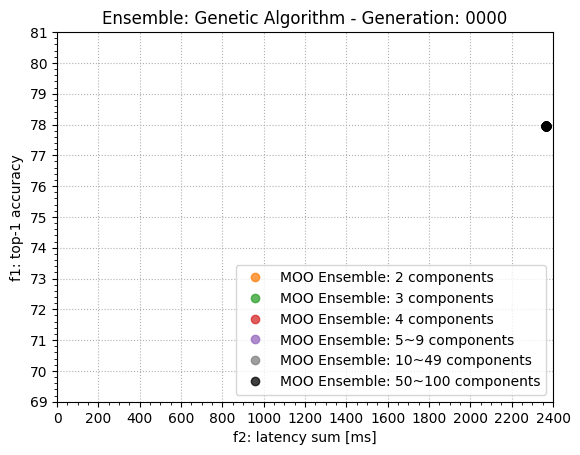

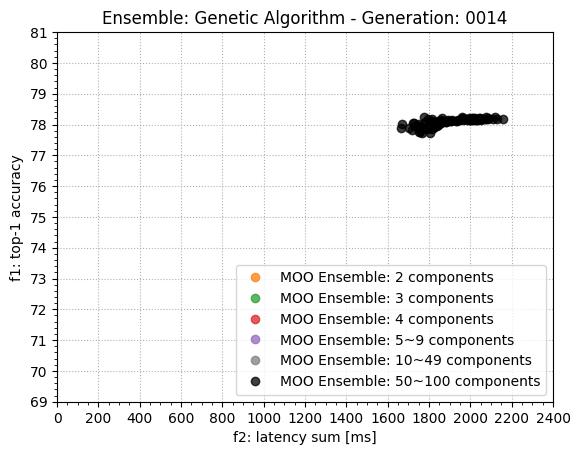

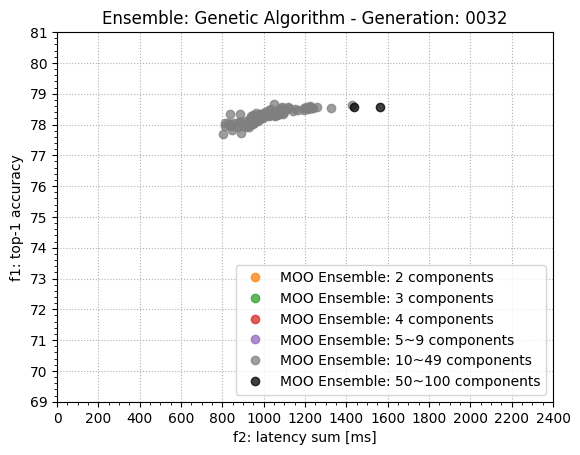

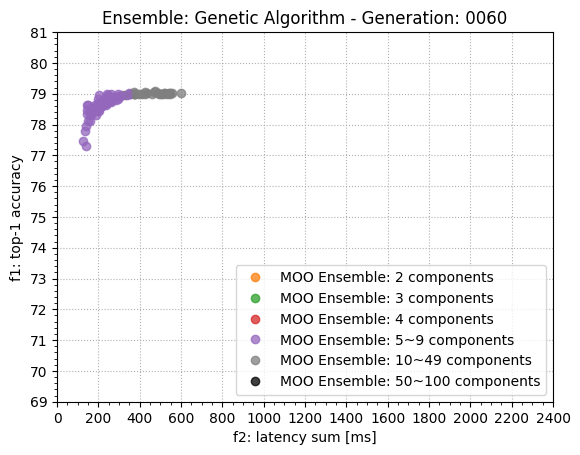

In [42]:
x_min, x_max, y_min, y_max = 0, 2400, 69, 81
ticks = [200, 50, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [0, 14, 32, 60]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latsum(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latsum', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population from 66

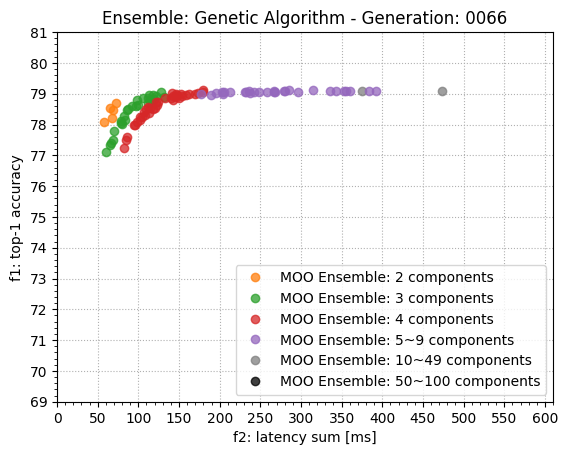

In [43]:
x_min, x_max, y_min, y_max = 0, 610, 69, 81
ticks = [50, 10, 1, 0.2]
#limit = [61, 100]
for i in [66]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latsum(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latsum', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 1000

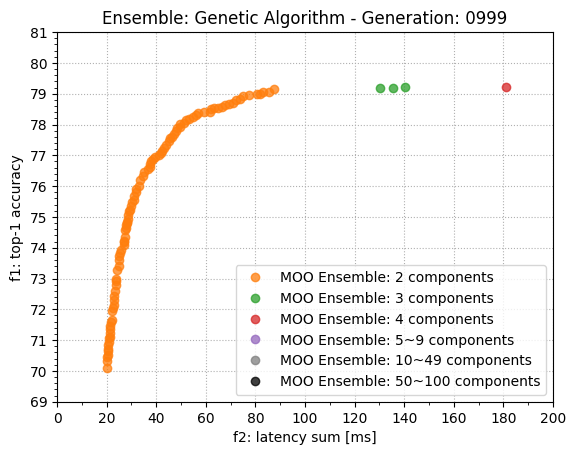

In [44]:
x_min, x_max, y_min, y_max = 0, 200, 69, 81
ticks = [20, 10, 1, 0.2]
#limit = [101, N]
for i in [999]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latsum(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latsum', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Comparison with single architectures

In [45]:
with open(os.path.join('tables', 'top1_moo_acc.pickle'), 'br') as f:
    top1_moo = pickle.load(f)

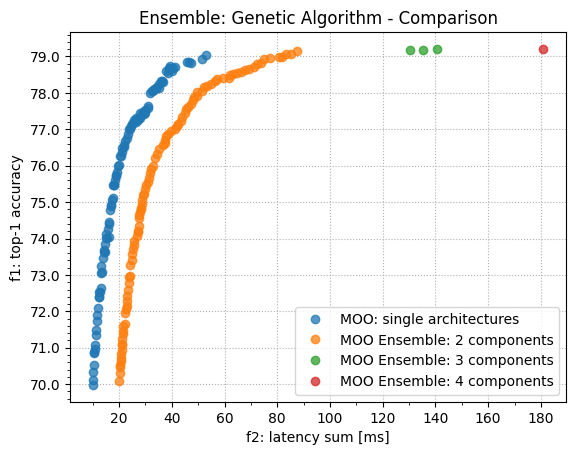

In [46]:
fig, ax = plt.subplots(dpi=600)
#-------------------------------------------------
ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.75, label='OFA²: single architectures')
#-------------------------------------------------
components = np.count_nonzero(X[-1], axis=1)
for i in range(len(lat[-1])):
    if components[i] == 2:
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
    elif components[i] == 3:
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
    elif components[i] == 4:
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='MOO: single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
ax.legend(handles=[leg_blue, leg_orange, leg_green, leg_red], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency sum [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Ensemble: Genetic Algorithm - Comparison'),
# ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('ensemble', 'NSGA-II', 'population-soft-latsum', '1000_comparison.png')
#plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

Generations #0, #14, #32, #60

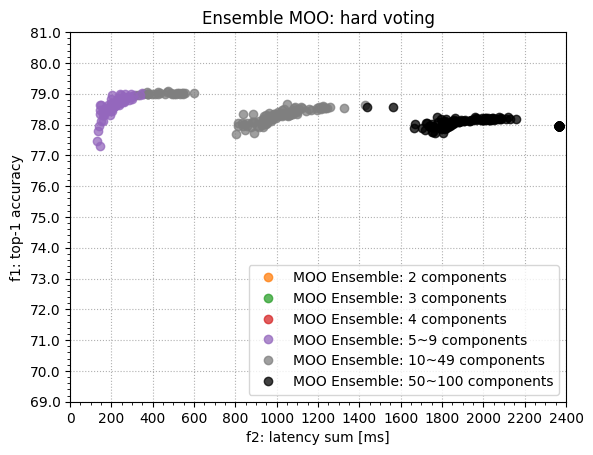

In [47]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 0, 2400, 69, 81
ticks = [200, 50, 1, 0.2]
generations = [0, 14, 32, 60]
#-------------------------------------------------
# ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.75, label='MOO: single architectures')
#-------------------------------------------------
for gen in generations:
    components = np.count_nonzero(X[gen], axis=1)
    for i in range(len(lat[gen])):
        if components[i] == 2:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='2 components')
        elif components[i] == 3:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='3 components')
        elif components[i] == 4:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='4 components')
        elif ( (components[i] >= 5) and (components[i] <= 9) ):
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=purple, alpha=0.75, label='5~9 components')
        elif ( (components[i] >= 10) and (components[i] <= 49) ):
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=gray, alpha=0.75, label='10~49 components')
        elif components[i] >= 50:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=black, alpha=0.75, label='50~100 components')
        # if components[i] == 2:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
        # elif components[i] == 3:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
        # elif components[i] == 4:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='MOO: single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 5~9 components')
leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 10~49 components')
leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 50~100 components')
ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency sum [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Ensemble MOO: hard voting'),
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('ensemble', 'NSGA-II', 'population-soft-latsum', 'gen_0_14_32_60.png')
#plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

In [48]:
# clean tensor from GPU memory
del ensemble_problem
del ensemble_res_nsga2
torch.cuda.empty_cache()

# Max Latency (components: 1 <= n <= 100)

In [49]:
P = 100
device = 'cuda:0'
# with open('moo_latency_table.pickle', 'rb') as f:
    # moo_latency_table = pickle.load(f)
with open(os.path.join('tables', 'top1_moo_table.pickle'), 'rb') as f:
    top1_moo_table = pickle.load(f)

In [50]:
# MOO: predicted latency/accuracy
with open('res_nsga2_results', 'rb') as f:
    res_moo = pickle.load(f)
res_moo_lat, res_moo_acc, res_moo_enc = zip(*res_moo)
# sort array by latency
sorted_idx = np.array(res_moo_lat).argsort()
res_moo_lat = np.array(res_moo_lat)[sorted_idx]
res_moo_acc = 100 - np.array(res_moo_acc)[sorted_idx]
res_moo_enc = np.array(res_moo_enc)[sorted_idx]

In [51]:
moo_latency_table = res_moo_lat.copy()

In [52]:
# MOO
with open(os.path.join('tables', 'topk_moo_table.pickle'), 'br') as f:
    topk_moo_table = pickle.load(f)
with open(os.path.join('tables', 'topk_moo_table_prob.pickle'), 'br') as f:
    topk_moo_table_prob = pickle.load(f)

In [53]:
# load labels
label_arr = topk_moo_table[0][:,-1]
label = torch.from_numpy(label_arr).to(cuda0)

In [54]:
debug = True
# debug = False
if debug:
    N_CLASSES = 1000
    n_models = topk_moo_table.shape[-1] - 1
    ds_size = topk_moo_table.shape[1]
    
    # GPU
    #cumulative_moo_table = torch.empty(n_models, ds_size, N_CLASSES, dtype=float, device=cuda0)
    # CPU
    cumulative_moo_table = torch.empty(n_models, ds_size, N_CLASSES, dtype=float)
    for model_id in tqdm(range(n_models)):
        with open(os.path.join('tables', 'prob_moo', 'cumulative_moo_table_' + str(model_id).zfill(2) + '.pickle'), 'br') as f:
            cumulative_moo_table[model_id] = pickle.load(f)

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


In [55]:
cumulative_moo_table.to_sparse()

tensor(indices=tensor([[    0,     0,     0,  ...,    99,    99,    99],
                       [    0,     0,     0,  ..., 49998, 49998, 49998],
                       [    0,   306,   391,  ...,   714,   728,   999]]),
       values=tensor([0.6828, 0.0139, 0.0219,  ..., 0.0424, 0.0486, 0.1321]),
       size=(100, 49999, 1000), nnz=24999975, dtype=torch.float64,
       layout=torch.sparse_coo)

## Individual

In [56]:
class EnsembleIndividual(Individual):
    def __init__(self, ensemble_selection, config=None, **kwargs):
        super().__init__(config=None, **kwargs)
        self.X = ensemble_selection

## Population

In [57]:
# from pareto front
pop = Population(individuals=[EnsembleIndividual(ind) for ind in np.identity(P)])

## Problem

In [58]:
# participation
part_var = Choice(options=[0, 1])
ensemble_size = P

In [59]:
class EnsembleProblemSoft(ElementwiseProblem):
    def __init__(self, ensemble_size, cumulative_table, latency_table, label, table='moo'):
        super().__init__(
            # n_var = 100,
            vars=ensemble_size * [part_var],
            n_obj=2,
            n_constr=1,
            # xl = -2.0,
            # xu = 2.0
        )
        # allocate in GPU 
        device = 'cuda:0'
        
        self.label = label
        self.val_size = torch.tensor(len(label)).to(device)
        
        self.N_CLASSES = 1_000
        self.latency_table = latency_table
        self.path = os.path.join('tables', 'prob_' + table, 'cumulative_' + table + '_table_')
        # reshape to (50k x 1k x 100)
        self.cumulative_table = torch.permute(cumulative_table, (1, 2, 0)).to(device)
    
    def calc_ensemble_lat_sum(self, x):
        return np.inner(x, self.latency_table)
    
    def calc_ensemble_lat_max(self, x):
        return max(np.multiply(x, self.latency_table))

    def calc_ensemble_accuracy(self, x):
        ind = torch.tensor(x, device=device)
        out = torch.matmul(self.cumulative_table, ind)
        acc = torch.count_nonzero(torch.argmax(out, axis=1) == self.label) / self.val_size * 100
        return acc.item()
        
    def _evaluate(self, x, out, *args, **kwargs):
        #f1 = self.calc_ensemble_lat_sum(x)
        f1 = self.calc_ensemble_lat_max(x)
        acc = self.calc_ensemble_accuracy(x)
        f2 = 100 - acc
        # ensemble must contains at least 2 components
        #   k = np.count_nonzero(x, axis=1)
        #   k >= 2, putting in the form of constraint <= 0 (pymoo's formulation)
        #   2 - k <= 0
        #g1 = 2 - np.count_nonzero(x, axis=1)
        #g1 = 2 - np.count_nonzero(x)    # n_components >= 2
        g1 = 1 - np.count_nonzero(x)    # n_components >= 1
        out["F"] = np.column_stack([f1, f2])
        out["G"] = [g1]

In [60]:
ensemble_problem = EnsembleProblemSoft(P, cumulative_moo_table, moo_latency_table, label, table='moo')

## Operators

Mutation

In [62]:
# Mutation (random)
ensemble_mutation_rc = ChoiceRandomMutation(prob=1.0, prob_var=0.01)
# ensemble_mutation_rc = EnsembleChoiceRandomMutation(prob_var=0.01)

Crossover

In [64]:
# Crossover (uniform)
ensemble_crossover_ux = UniformCrossover(prob=1.0)
parents = [[pop[0], pop[1]] for _ in range(1)]

Sampling (random)

In [65]:
class EnsembleSampling(Sampling):
    def _do(self, ensemble_problem, n_samples, **kwargs):
        return [
            [np.random.choice(var.options) for var in ensemble_problem.vars]
            for _ in range(n_samples)
        ]

In [66]:
ensemble_sampling = EnsembleSampling()

Termination

In [67]:
ensemble_termination_gen = get_termination("n_gen", 1000)

## Algorithm

NSGA-II

In [68]:
# from pymoo.operators.selection.tournament import compare, TournamentSelection
# from pymoo.util.display.multi import MultiObjectiveOutput

ensemble_algorithm = NSGA2(
    pop_size=P,
    #sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.identity(P)]),
    sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.ones((P,P))]),
    crossover=ensemble_crossover_ux,
    mutation=ensemble_mutation_rc,
)

SMS-EMOA

In [69]:
#ensemble_algorithm_smsemoa = SMSEMOA(
#    pop_size=P,
#    # sampling=ensemble_sampling,
#    sampling=Population(individuals=[EnsembleIndividual(ind) for ind in np.identity(P)]),
#    #selection=selection_tournament,
#    crossover=crossover_ux,
#    mutation=mutation_rc,
#    # mutation=mutation_pm,
#    # survival=RankAndCrowdingSurvival(),
#    # output=MultiObjectiveOutput(),
#    #    **kwargs
#)

## Optimization

In [70]:
class MyCallback(Callback):
    
    def __init__(self) -> None:
        super().__init__()
        self.data = []
        
    def notify(self, algorithm):
        pop_data = algorithm.n_gen, algorithm.pop.get("X"), algorithm.pop.get("F"), algorithm.pop.get("G")
        filename = 'gen_' + str(algorithm.n_gen).zfill(4) + '.pickle'
        with open(os.path.join('ensemble', 'NSGA-II', 'generation-latmax_norestriction_single', filename), 'bw') as f:
            pickle.dump(pop_data, f)

In [71]:
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        self.n_gen = Column("n_gen", width=5)
        #self.g_mean = Column("g_mean", width=6)
        #self.g_min = Column("g_mean", width=6)
        #self.g_max = Column("g_mean", width=6)
        self.lat_min = Column("lat_min", width=15)
        self.lat_max = Column("lat_max", width=15)
        self.acc_min = Column("acc_min", width=15)
        self.acc_max = Column("acc_max", width=15)
        self.acc_mean = Column("acc_mean", width=15)
        #self.columns = [self.n_gen, self.g_mean, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.g_min, self.g_max, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        self.columns = [self.n_gen, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.g_mean]#, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]
        #self.columns = [self.n_gen, self.lat_min, self.lat_max, self.acc_min, self.acc_max, self.acc_mean]

    def update(self, algorithm):
        super().update(algorithm)
        self.n_gen.set(algorithm.n_gen)
        #self.g_mean.set(2 - algorithm.pop.get("G"))
        #self.g_mean.set(np.mean(2 - algorithm.pop.get("G")[:]).item())
        #self.g_min.set(np.abs(np.min(algorithm.pop.get("G"))))
        #self.g_max.set(np.abs(np.max(algorithm.pop.get("G"))))
        self.lat_min.set(np.min(algorithm.pop.get("F")[:,0]))
        self.lat_max.set(np.max(algorithm.pop.get("F")[:,0]))
        self.acc_min.set(np.min(100 - algorithm.pop.get("F")[:,1]))
        self.acc_max.set(np.max(100 - algorithm.pop.get("F")[:,1]))
        self.acc_mean.set(np.mean(100 - algorithm.pop.get("F")[:,1]))

In [72]:
N = 1_000
ensemble_termination_gen = get_termination("n_gen", N)

In [73]:
# start measuring time
start_time = time.time()

ensemble_res_nsga2 = minimize(
    ensemble_problem,
    ensemble_algorithm,
    callback=MyCallback(),
    # termination=ensemble_termination_gen,
    termination=get_termination("n_gen", N),
    seed=1,
    verbose=True,
    output=MyOutput(),
    save_history=False,
)

# stop measuring time
end_time = time.time()

n_gen |     lat_min     |     lat_max     |     acc_min     |     acc_max     |     acc_mean   
    1 |  5.29876057E+01 |  5.29876057E+01 |  7.79675598E+01 |  7.79675598E+01 |  7.79675598E+01
    2 |  5.29876057E+01 |  5.29876057E+01 |  7.78775558E+01 |  7.80155563E+01 |  7.79642191E+01
    3 |  5.15203700E+01 |  5.29876057E+01 |  7.79255600E+01 |  7.80155563E+01 |  7.79878191E+01
    4 |  5.15203700E+01 |  5.29876057E+01 |  7.79155579E+01 |  7.80535660E+01 |  7.79997395E+01
    5 |  5.15203700E+01 |  5.29876057E+01 |  7.79155579E+01 |  7.80815582E+01 |  7.80124203E+01
    6 |  5.15203700E+01 |  5.29876057E+01 |  7.79155579E+01 |  7.81275635E+01 |  7.80195206E+01
    7 |  5.15203700E+01 |  5.29876057E+01 |  7.79635620E+01 |  7.81615601E+01 |  7.80375004E+01
    8 |  4.72298630E+01 |  5.29876057E+01 |  7.79615555E+01 |  7.81715622E+01 |  7.80626814E+01
    9 |  4.72298630E+01 |  5.29876057E+01 |  7.79615555E+01 |  7.81775665E+01 |  7.80938824E+01
   10 |  4.72298630E+01 |  5.29876057E+0

In [74]:
elapsed = end_time - start_time
print('The optimization took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization took 01h58m46s to finish.


## Plot history

In [75]:
with open(os.path.join('tables', 'top1_moo_acc.pickle'), 'br') as f:
    top1_moo = pickle.load(f)

In [76]:
def plot_ensemble_performance_latmax(latency, accuracy, X, title='Population', ensemble=False, ax_limits=None, filename=None, show=True, color='#1f77b4', ticks=None):
    leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='MOO: single architectures')
    leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
    leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
    leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
    leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 5~9 components')
    leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 10~49 components')
    leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 50~100 components')
    if (filename is not None):
        fig, ax = plt.subplots(dpi=600)
    else:
        fig, ax = plt.subplots(dpi=100)
    if ensemble:
        components = np.count_nonzero(X, axis=1)
        for i, c in enumerate(components):
            if c == 1:
                ax.plot(latency[i], accuracy[i], 'o', color=blue, alpha=0.75, label='MOO: single architectures')
            if c == 2:
                ax.plot(latency[i], accuracy[i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
            elif c == 3:
                ax.plot(latency[i], accuracy[i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
            elif c == 4:
                ax.plot(latency[i], accuracy[i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
            elif ( (c >= 5) and (c <= 9) ):
                ax.plot(latency[i], accuracy[i], 'o', color=purple, alpha=0.75, label='MOO Ensemble: 5~9 components')
            elif ( (c >= 10) and (c <= 49) ):
                ax.plot(latency[i], accuracy[i], 'o', color=gray, alpha=0.75, label='MOO Ensemble: 10~49 components')
            elif ( (c >= 50) and (c <= 100) ):
                ax.plot(latency[i], accuracy[i], 'o', color=black, alpha=0.75, label='MOO Ensemble: 50~100 components')
        #ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.15, label='MOO: single architectures')
        # ax.legend(handles=[blue, orange, green, red, gray, black], loc='lower right')
        #ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_olive, leg_gray, leg_black], loc='lower right')
        #ax.legend(handles=[leg_blue, leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        # ax.legend()
        ax.grid(True, linestyle=':')
        ax.set_xlabel('f2: latency max [ms]')
        ax.set_ylabel('f1: top-1 accuracy')
        # fig.suptitle(title)
        ax.set_title(title),
        if ticks is not None:
            # x-axis ticks
            ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
            ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
            # y-axis ticks
            ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
            ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
        if ax_limits is not None:
            ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
        if (filename is not None):
            plt.savefig(filename)
        if not show:
            plt.close(fig)

In [77]:
N = 1_000
history = []
    
debug = True
# debug = False
if debug:
    for generation in tqdm(range(1, N+1)):
        filename = 'gen_' + str(generation).zfill(4) + '.pickle'
        with open(os.path.join('ensemble', 'NSGA-II', 'generation-latmax_norestriction_single', filename), 'br') as f:
            _, X, F, G = pickle.load(f)
        history.append((X, F, G))

100%|██████████| 1000/1000 [00:00<00:00, 1449.61it/s]


In [78]:
X = []
lat = []
acc = []
size = []
for hist in history:
    X.append(hist[0])
    lat.append(hist[1][:,0])
    acc.append(hist[1][:,1])
    size.append(2 - hist[2])
# fix first generation
X[0] = np.repeat(X[0], P, axis=0)
lat[0] = np.repeat(lat[0], P, axis=0)
acc[0] = np.repeat(acc[0], P, axis=0)
size[0] = np.repeat(size[0], P, axis=0)

Population 0 

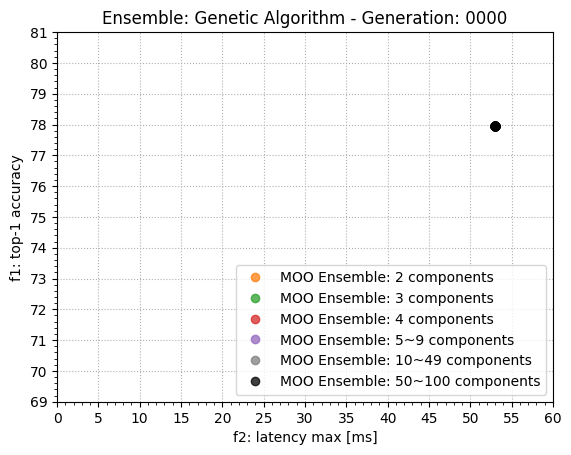

In [79]:
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
#limit = [0, N]
#for i in tqdm(range(limit[0], limit[1])):
for i in [0]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latmax(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 38

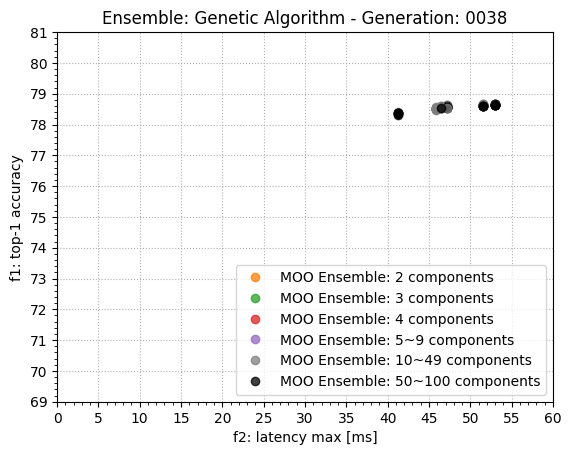

In [80]:
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
#limit = [0, N]
#for i in tqdm(range(limit[0], limit[1])):
for i in [38]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latmax(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 179

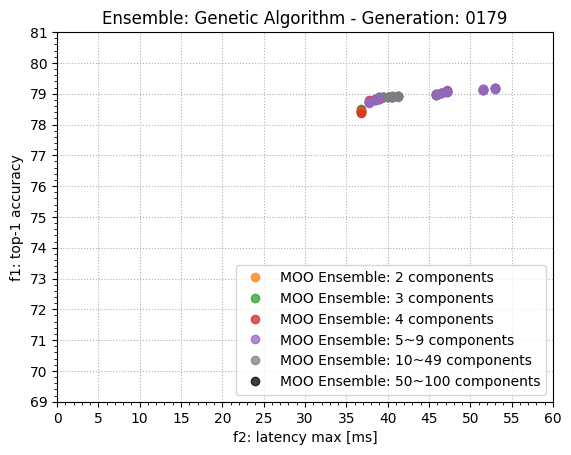

In [81]:
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
#limit = [0, N]
#for i in tqdm(range(limit[0], limit[1])):
for i in [179]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latmax(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 212

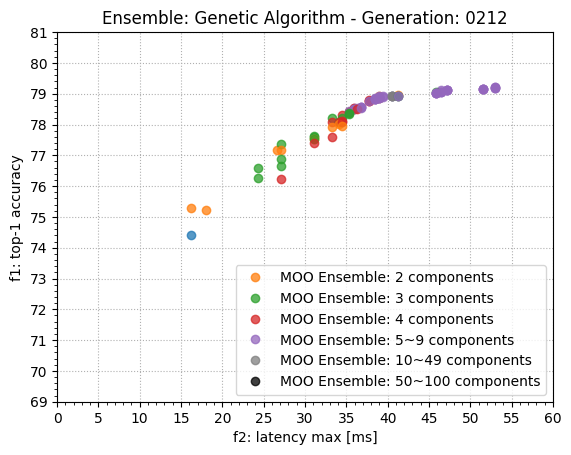

In [82]:
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
#limit = [0, N]
#for i in tqdm(range(limit[0], limit[1])):
for i in [212]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latmax(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 1_000

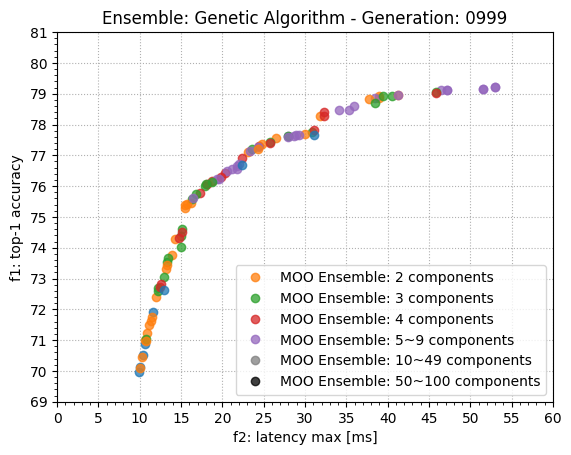

In [83]:
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
#limit = [0, N]
#for i in tqdm(range(limit[0], limit[1])):
for i in [999]:
    filename = str(i).zfill(len(str(N))) + '.png'
    plot_ensemble_performance_latmax(
        lat[i],
        100 - acc[i],
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        #filename=os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', filename),
        filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Comparison with single architectures

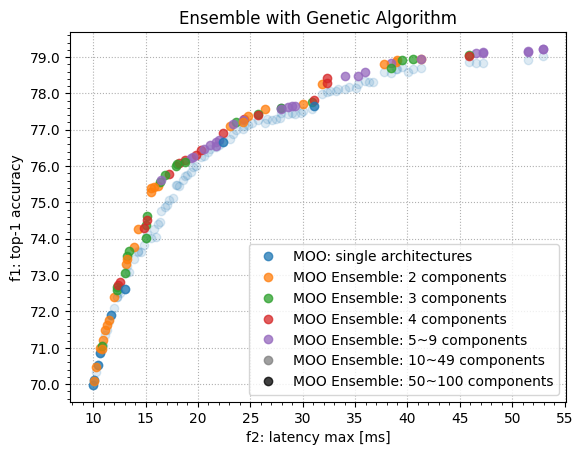

In [84]:
fig, ax = plt.subplots(dpi=600)
#-------------------------------------------------
ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.15, label='MOO: single architectures')
#-------------------------------------------------
#components = np.count_nonzero(X[-1], axis=1)

#X[-1] = np.delete(X[-1], 9, axis=0)
#lat[-1] = np.delete(lat[-1], 9, axis=0)
#acc[-1] = np.delete(acc[-1], 9, axis=0)
components = np.count_nonzero(X[-1], axis=1)

for i in range(len(lat[-1])):
    if (components[i] >= 50):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=black, alpha=0.75, label='MOO Ensemble: 50~100 components')
    elif ( (components[i] >= 10) and (components[i] <= 49) ):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=gray, alpha=0.75, label='MOO Ensemble: 10~49 components')
    elif ( (components[i] >= 5) and (components[i] <= 9) ):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=purple, alpha=0.75, label='MOO Ensemble: 5~9 components')
    elif (components[i] == 4):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
    elif (components[i] == 3):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
    elif (components[i] == 2):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
    elif (components[i] == 1):
        ax.plot(lat[-1][i], 100 - acc[-1][i], 'o', color=blue, alpha=0.75, label='MOO: single architectures')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='MOO: single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 5~9 components')
leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 10~49 components')
leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 50~100 components')
#ax.legend(handles=[leg_blue, leg_orange, leg_green, leg_red, leg_purple], loc='lower right')
ax.legend(handles=[leg_blue, leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency max [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Ensemble with Genetic Algorithm'),
# ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', '1000_comparison.png')
#plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

Generations #0, #38, #179

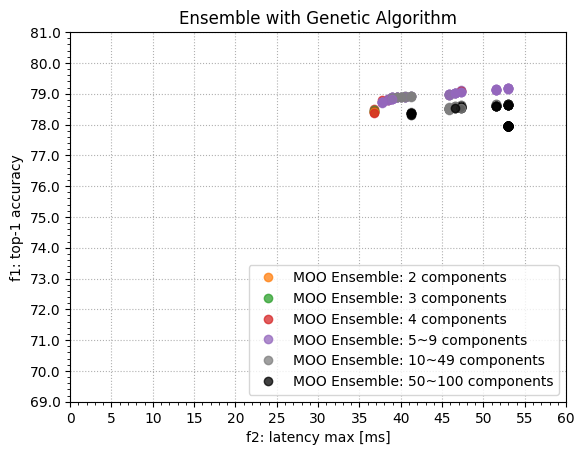

In [85]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 0, 60, 69, 81
ticks = [5, 1, 1, 0.2]
generations = [0, 38, 179]
#-------------------------------------------------
#ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.10, label='MOO: single architectures')
#-------------------------------------------------
for gen in generations:
    components = np.count_nonzero(X[gen], axis=1)
    for i in range(len(lat[gen])):
        if components[i] == 2:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='2 components')
        elif components[i] == 3:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='3 components')
        elif components[i] == 4:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='4 components')
        elif ( (components[i] >= 5) and (components[i] <= 9) ):
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=purple, alpha=0.75, label='5~9 components')
        elif ( (components[i] >= 10) and (components[i] <= 49) ):
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=gray, alpha=0.75, label='10~49 components')
        elif components[i] >= 50:
            ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=black, alpha=0.75, label='50~100 components')
        # if components[i] == 2:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
        # elif components[i] == 3:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
        # elif components[i] == 4:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='MOO: single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 4 components')
leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 5~9 components')
leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 10~49 components')
leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='MOO Ensemble: 50~100 components')
ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency max [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Ensemble with Genetic Algorithm'),
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('ensemble', 'NSGA-II', 'population-soft-latmax_norestriction_single', 'gen_0_38_179.png')
#plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

# End